<a href="https://colab.research.google.com/github/tjrgh822/class_itsystem/blob/master/hw3/hw3_by_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from __future__ import print_function
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


(x_train, y_train), (x_test, y_test) = mnist.load_data()



                             

nodatagen = ImageDataGenerator()



In [0]:
from tensorflow.keras.utils import Sequence

class dim4_input(Sequence):
  def __init__(self, x_data, y_data, batch_size):
    self.x_data = np.array(x_data).astype(np.float32)
    self.y_data = np.array(y_data).astype(np.float32)
    self.batch_size = batch_size
    self.indices = np.random.permutation(len(x_data))
  
  def __len__(self):
    return len(self.x_data) // self.batch_size
  
  def __getitem__(self, idx):
    batch_idx = self.indices[idx*self.batch_size: (idx+1)* self.batch_size]
    x_batch = self.x_data[batch_idx]
    y_batch = self.y_data[batch_idx]

    x_batch1 = np.rot90(x_batch,axes=(-3,-2))
    x_batch2 = np.rot90(x_batch1,axes=(-3,-2))
    x_batch3 = np.rot90(x_batch2,axes=(-3,-2))
    
    x = (np.concatenate((np.expand_dims(x_batch, axis=3), 
                        np.expand_dims(x_batch1, axis=3), 
                        np.expand_dims(x_batch2, axis=3),  
                        np.expand_dims(x_batch3, axis=3)), axis=3) / 255).reshape(-1, 28, 28, 4)
    y = np.array(tf.keras.utils.to_categorical(y_batch, 10))

    return x, y
  
  def on_epoch_end(self):
    self.indices = np.random.permutation(len(self.x_data))
    
      

    


In [0]:
datagen = ImageDataGenerator(width_shift_range=3, 
                             height_shift_range=3, 
                             horizontal_flip=True, 
                             vertical_flip=True,
                             brightness_range = [0.2, 1.0],
                             rotation_range = 90,
                             zoom_range = [0.7, 1.0]
                             )

augment_train = datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, len(x_train))
augment_test = datagen.flow(x_test.reshape(-1, 28, 28, 1), y_test, len(x_test))

train_set =  dim4_input( augment_train[0][0],augment_train[0][1], batch_size=batch_size)
test_set = dim4_input(augment_test[0][0],augment_test[0][1], len(x_test))

In [136]:

model = Sequential()


# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(28,28,4), kernel_size=(11,11), padding="valid", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(units = 2048, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# 3rd Fully Connected Layer
model.add(Dense(1024, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(10, activation = "softmax")) #As we have two classes

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 18, 18, 96)        46560     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 96)          0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 96)          384       
_________________________________________________________________
dropout_20 (Dropout)         (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 256)         614656    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 3, 3, 256)        

In [138]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

def scheduler(epoch):
  if epoch < 10:
    return 0.0008
  else:
    return 0.0008 * tf.math.exp(0.1 * (10 - epoch)/1.5)

Lschedule = LearningRateScheduler(scheduler)

batch_size = 100
epochs = 50

checkpointer = ModelCheckpoint(
    filepath='model_8.h5',
    save_best_only=True
)
early_stopping = EarlyStopping(patience=10)

callbacks=[checkpointer, early_stopping, Lschedule]


hist = model.fit(train_set,
          steps_per_epoch = len(train_set), 
          epochs=epochs,
          verbose=1,
          validation_data= test_set,
          validation_steps = len(test_set),
          callbacks= callbacks
          )

Epoch 1/50
600/600 [==============================] - 6s 11ms/step - loss: 1.2028 - accuracy: 0.5864 - val_loss: 1.0405 - val_accuracy: 0.6322 - lr: 8.0000e-04
Epoch 2/50
600/600 [==============================] - 6s 10ms/step - loss: 0.9995 - accuracy: 0.6592 - val_loss: 0.8880 - val_accuracy: 0.6929 - lr: 8.0000e-04
Epoch 3/50
600/600 [==============================] - 6s 10ms/step - loss: 0.8748 - accuracy: 0.7058 - val_loss: 0.7823 - val_accuracy: 0.7357 - lr: 8.0000e-04
Epoch 4/50
600/600 [==============================] - 6s 10ms/step - loss: 0.7866 - accuracy: 0.7369 - val_loss: 0.6318 - val_accuracy: 0.7852 - lr: 8.0000e-04
Epoch 5/50
600/600 [==============================] - 6s 10ms/step - loss: 0.7217 - accuracy: 0.7554 - val_loss: 0.5936 - val_accuracy: 0.7949 - lr: 8.0000e-04
Epoch 6/50
600/600 [==============================] - 6s 10ms/step - loss: 0.6645 - accuracy: 0.7771 - val_loss: 0.5369 - val_accuracy: 0.8164 - lr: 8.0000e-04
Epoch 7/50
600/600 [====================

(28, 28)


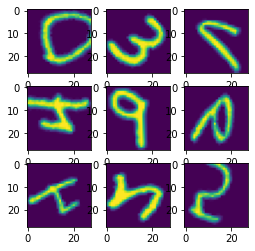

In [130]:

print(test_set[0][0][1, :, :, 1].shape)

plt.figure(figsize=(4, 4))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(test_set[0][0][i,:, :, 1])
plt.show()

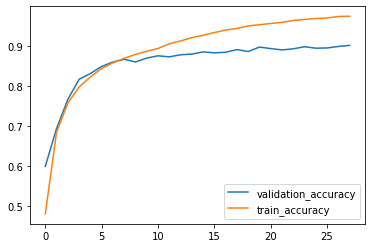

In [134]:
plt.figure()
plt.plot(hist.history['val_accuracy'], label = 'validation_accuracy')
plt.plot(hist.history['accuracy'], label = 'train_accuracy')
plt.legend(loc = 'lower right')
plt.show()



> 들여쓴 블록



In [0]:
from google.colab import drive

drive.mount('/content/drive')

In [0]:
model.save('/content/drive/My Drive/colab/robust_by_model.h5')

In [142]:
noise_loss_hist = []
noise_acc_hist = []

for i in range(10):
    print(f"~~~~~{i}~~~~~~~~~")
    for k in range(10):
      test_datagen = ImageDataGenerator( width_shift_range= 2* i, 
                                  height_shift_range= 2*i, 
                                  horizontal_flip=True, 
                                  vertical_flip=True,
                                  brightness_range = [0.2, 1.0],
                                  rotation_range = 4*k,
                                  zoom_range = [ 1.0 - 0.8 /10 * i, 1.0 ]
                                  )

      augment_test = test_datagen.flow(x_test.reshape(-1, 28, 28, 1), y_test, len(x_test))
      test_set = dim4_input(augment_test[0][0],augment_test[0][1], len(x_test))

      val_loss = model.evaluate(test_set, steps = len(test_set))

      #print(val_loss)
      noise_loss_hist.append([ [i*2], [k*4], [val_loss[0]]])
      noise_acc_hist.append([ [i*2], [k*4], [val_loss[1]] ])

~~~~~0~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.2663 - accuracy: 0.9200
~~~~~1~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.2607 - accuracy: 0.9195
~~~~~2~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.4064 - accuracy: 0.8783
~~~~~3~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 1.3274 - accuracy: 0.6955
~~~~~4~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 3.2680 - accuracy: 0.4788
~~~~~5~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 5.6120 - accuracy: 0.3548
~~~~~6~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 9.0618 - accuracy: 0.2735
~~~~~7~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 14.6077 - accuracy: 0.2197
~~~~~8~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 21.8969 - accuracy: 0.1874
~~~~~9~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 28.3751 - accu

No handles with labels found to put in legend.


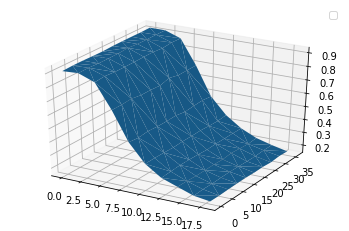

In [143]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np           
import matplotlib.pyplot as plt  

noise_acc_hist = np.squeeze( np.array(noise_acc_hist))

fig = plt.figure()							
ax = fig.gca(projection='3d')
ax.plot_trisurf(noise_acc_hist[:, 0], noise_acc_hist[:, 1], noise_acc_hist[:, 2])	
ax.legend()										

plt.show()

In [6]:
noise_loss_hist = []
noise_acc_hist = []

for i in range(10):
    print(f"~~~~~{i}~~~~~~~~~")
    for k in range(10):
      test_datagen = ImageDataGenerator( width_shift_range= 2, 
                                  height_shift_range= 2, 
                                  horizontal_flip=True, 
                                  vertical_flip=True,
                                  brightness_range = [0.2, 1.0],
                                  rotation_range = 4*k,
                                  zoom_range = [ 1.0 - 0.8 /10 * i, 1.0 ]
                                  )

      augment_test = test_datagen.flow(x_test.reshape(-1, 28, 28, 1), y_test, len(x_test))
      test_set = dim4_input(augment_test[0][0],augment_test[0][1], len(x_test))

      val_loss = model.evaluate(test_set, steps = len(test_set))

      #print(val_loss)
      noise_loss_hist.append([ [i*2], [k*4], [val_loss[0]]])
      noise_acc_hist.append([ [i*2], [k*4], [val_loss[1]] ])

~~~~~0~~~~~~~~~
1/1 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.9099
~~~~~1~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.2613 - accuracy: 0.9213
~~~~~2~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.2633 - accuracy: 0.9190
~~~~~3~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.2605 - accuracy: 0.9203
~~~~~4~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.2855 - accuracy: 0.9133
~~~~~5~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.3427 - accuracy: 0.8993
~~~~~6~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.5013 - accuracy: 0.8594
~~~~~7~~~~~~~~~
1/1 [==============================] - 0s 2ms/step - loss: 0.8118 - accuracy: 0.7989
~~~~~8~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 1.2522 - accuracy: 0.7170
~~~~~9~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 1.8567 - accurac

No handles with labels found to put in legend.


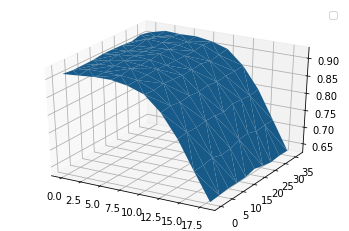

In [7]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np           
import matplotlib.pyplot as plt  

noise_acc_hist = np.squeeze( np.array(noise_acc_hist))

fig = plt.figure()							
ax = fig.gca(projection='3d')
ax.plot_trisurf(noise_acc_hist[:, 0], noise_acc_hist[:, 1], noise_acc_hist[:, 2])	
ax.legend()										

plt.show()

In [0]:

model =tf.keras.models.load_model('/content/drive/My Drive/colab/robust_by_model.h5')